In [28]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training different architectures

## I downloaded additional surface event data, the step below is just processing those additionally downloaded waveforms and these will be added later to the the total dataset. 

In [8]:
nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = - 40
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()


num_channels = 3
# new sampling rate
fs = 50

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100

# randomly starting between -40 to -5s
start = -40

In [9]:
def process_surface_events(data_path, ids_path, fs=50, original_fs = 100, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-40, -5)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)


    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]
            
            orig_fs = 100
            
            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs
            
            # assuming the onset at 90s
            start_idx = int(90 * orig_fs) + random_shift
            end_idx = start_idx + int(window_length * orig_fs)
            
    
            # Handle boundary conditions
            max_idx = event_data.shape[-1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * orig_fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * orig_fs)
                
                
            sliced = event_data[:, start_idx:end_idx]
            sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

            
            processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut)
            
            processed = processor(sliced_tensor)  # (C, T)
          
        
            if processed.shape[-1] != int(window_length*fs):
                print('error')
                continue

            x = processed.numpy()
            
            if len(x) == 3:  # Ensure the event has three components
                processed_data.append(x)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../../data/new_curated_surface_event_data.npy'
ids_path = '../../data/new_curated_surface_event_ids.json'

processed, processed_id = process_surface_events(data_path, ids_path)

Processing events: 100%|██████████| 6495/6495 [00:11<00:00, 581.16it/s]


## Loading the stored data

In [10]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]

In [11]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Collecting three component waveforms

In [12]:
number_data_per_class = len(df_su)
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)



number_data_per_class = 15000
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



number_data_per_class = len(df_exp)
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)


number_data_per_class = 17000
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)

  0%|          | 10/15000 [00:00<02:38, 94.47it/s]

(3778, 3, 5000)


  0%|          | 7/13638 [00:00<03:26, 66.01it/s]

(10644, 3, 5000)


  0%|          | 0/17000 [00:00<?, ?it/s]

(8749, 3, 5000)


100%|██████████| 17000/17000 [03:54<00:00, 72.49it/s]


(10474, 3, 5000)


## Prepare data

Now we will add the newly downloaded surface events data to the existing three channel surface events. This will give us about 10k waveforms per class. So total 40k waveforms per class, we will divide these into test and train, save the test. This test dataset will be commonly evaluated across DL and ML algorithms. 

In [13]:
def prepare_data(d_eq, d_exp, d_noise, d_su, processed, processed_ids, num_samples=10000):
    """
    Prepares and concatenates seismic data for training and testing.
    
    Args:
        d_eq, d_exp, d_noise, d_su (array): Arrays of waveform data for different classes.
        processed (array): Processed surface waveforms.
        processed_ids (array): Corresponding IDs for processed surface waveforms.
        num_samples (int): Number of samples to extract per class.

    Returns:
        tuple: Combined waveforms (new_X_1d), event IDs (new_X), and labels (new_y).
    """
    # Extract the required number of samples per class
    new_d_eq = d_eq[:num_samples]
    new_d_exp = d_exp[:num_samples]
    new_d_no = d_noise[:num_samples]
    new_d_su = np.concatenate([d_su, np.array(processed)])[:num_samples]

    # Extract corresponding event IDs
    new_id_eq = id_eq[:num_samples]
    new_id_exp = id_exp[:num_samples]
    new_id_no = id_noise[:num_samples]
    new_id_su = np.concatenate([id_su, np.array(processed_ids)])[:num_samples]

    # Combine data into single arrays
    new_X_1d = np.vstack([new_d_eq, new_d_exp, new_d_no, new_d_su])  # Waveforms
    new_X = np.hstack([new_id_eq, new_id_exp, new_id_no, new_id_su])  # Event IDs
    new_y = (
        [0] * len(new_d_eq) + 
        [1] * len(new_d_exp) + 
        [2] * len(new_d_no) + 
        [3] * len(new_d_su)
    )  # Labels
    
    return new_X_1d, new_X, new_y

def split_and_save_data(new_X, new_X_1d, new_y, test_size=0.2, random_state=42, save_path="../../data"):
    """
    Splits data into training and testing, and saves the results to disk.
    
    Args:
        new_X (array): Event IDs.
        new_X_1d (array): Waveform data.
        new_y (list): Labels for the event IDs.
        test_size (float): Proportion of test data.
        random_state (int): Random state for reproducibility.
        save_path (str): Directory to save the test data IDs.
    """
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        new_X, new_y, test_size=test_size, random_state=random_state, stratify=new_y
    )
    
    # Create a mapping of event IDs to indices
    event_id_to_index = {event_id: idx for idx, event_id in enumerate(new_X)}
    
    # Retrieve indices for test and train data
    test_indices = [event_id_to_index[event_id] for event_id in X_test]
    train_indices = [event_id_to_index[event_id] for event_id in X_train]
    
    # Extract waveforms for train and test sets
    test_waveforms = new_X_1d[test_indices]
    train_waveforms = new_X_1d[train_indices]
    
    # Save test data IDs for future use
    np.save(f"{save_path}/common_test_data_id.npy", X_test)
    np.save(f"{save_path}/common_test_data_for_deep_learning.npy", test_waveforms)
    np.save(f"{save_path}/common_test_data_labels_for_deep_learning.npy", y_test)
    
    print("Shape of test_waveforms:", test_waveforms.shape)
    print("Shape of train_waveforms:", train_waveforms.shape)

    return train_waveforms, test_waveforms, y_train, y_test


# Example usage:
new_X_1d, new_X, new_y = prepare_data(d_eq, d_exp, d_noise, d_su, processed, processed_id, num_samples=10000)
train_waveforms, test_waveforms, y_train, y_test = split_and_save_data(new_X, new_X_1d, new_y)

Shape of test_waveforms: (7750, 3, 5000)
Shape of train_waveforms: (30999, 3, 5000)


## Data Augmentation Strategy
We began with approximately 40,000 waveform samples, evenly distributed across four classes: earthquakes, explosions, surface events, and noise. The dataset was initially split into:

Training set: 80% → 32,000 samples

Test set: 20% → 8,000 samples

To improve model robustness and generalization, we applied additive noise augmentation to the training set. Specifically, for each sample in the earthquake, explosion, and surface event classes, we added scaled noise traces sampled from the noise class.

This resulted in:

Augmented training set: Original 32,000 samples → 64,000 samples (with noise-augmented duplicates)

We then performed a train/validation split on the augmented training set:

Training set: 75% → 48,000 samples (~12,000 per class)

Validation set: 25% → 16,000 samples (~4,000 per class)

## Observations
This augmentation strategy significantly improved the performance of the 1D convolutional model.

The 1D model’s accuracy now closely matches that of the 2D (spectrogram-based) model, suggesting that robustness—not necessarily input type—was a limiting factor prior to augmentation.

In [14]:
def augment_with_noise_numpy(data, noise_pool, scale = 1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.randint(0, len(noise_pool), size=len(data))
    noise_samples = noise_pool[indices]
    
    return data + scale * noise_samples



y_train = np.array(y_train)

X_train = train_waveforms
d_eq_train  = X_train[y_train == 0]
d_exp_train = X_train[y_train == 1]
d_noise_train = X_train[y_train == 2]
d_su_train  = X_train[y_train == 3]



aug_eq  = augment_with_noise_numpy(d_eq_train, d_noise_train, scale=1)
aug_exp = augment_with_noise_numpy(d_exp_train, d_noise_train, scale=1)
aug_su  = augment_with_noise_numpy(d_su_train,  d_noise_train, scale= 1)
aug_no  = augment_with_noise_numpy(d_noise_train,  d_noise_train, scale= 1)


X_train_aug = np.concatenate([d_eq_train, d_exp_train, d_su_train, d_noise_train,
                         aug_eq, aug_exp, aug_su, aug_no], axis=0)
y_train_aug = torch.tensor(
    [0]*len(d_eq_train) + [1]*len(d_exp_train) + [3]*len(d_su_train) + [2]*len(d_noise_train) +
    [0]*len(aug_eq)      + [1]*len(aug_exp)      + [3]*len(aug_su) +[2]*len(aug_no)
)



## Preparing input data

In [26]:
X_1d = X_train_aug
X_1d = torch.tensor(X_1d, dtype = torch.float32)

spec = compute_spectrogram(X_1d, 50)
norm_spec = normalize_spectrogram_minmax(spec[0])

X_2d = norm_spec
y = y_train_aug


train_split =75
val_split = 25

train_loader_1d, val_loader_1d = return_train_val_loaders(X = X_1d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d = return_train_val_loaders(X = X_2d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)

Train batches: 363, Val batches: 121
Train batches: 363, Val batches: 121


## SeismicCNN (1D)

In [41]:
n_epochs = 100
device = 'cuda'
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, model_training_time_seismiccnn_1d) = train_model(model_seismiccnn_1d,
    train_loader_1d,  
    val_loader_1d,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    augmentation= False, 
    patience = 30, 
    model_path = '../trained_models/best_model_new_augmented_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:10<10:28,  6.98s/it]

[Epoch 10] loss: 0.200 - accuracy: 84.607


 20%|██        | 20/100 [02:20<09:15,  6.95s/it]

[Epoch 20] loss: 0.095 - accuracy: 86.603


 30%|███       | 30/100 [03:30<08:06,  6.96s/it]

[Epoch 30] loss: 0.064 - accuracy: 87.655


 40%|████      | 40/100 [04:40<06:57,  6.95s/it]

[Epoch 40] loss: 0.051 - accuracy: 88.126


 50%|█████     | 50/100 [05:50<05:48,  6.97s/it]

[Epoch 50] loss: 0.046 - accuracy: 88.113


 60%|██████    | 60/100 [07:00<04:39,  7.00s/it]

[Epoch 60] loss: 0.038 - accuracy: 88.210


 70%|███████   | 70/100 [08:09<03:29,  6.97s/it]

[Epoch 70] loss: 0.033 - accuracy: 89.211


 70%|███████   | 70/100 [08:16<03:32,  7.10s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:590: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

## Plotting model performance

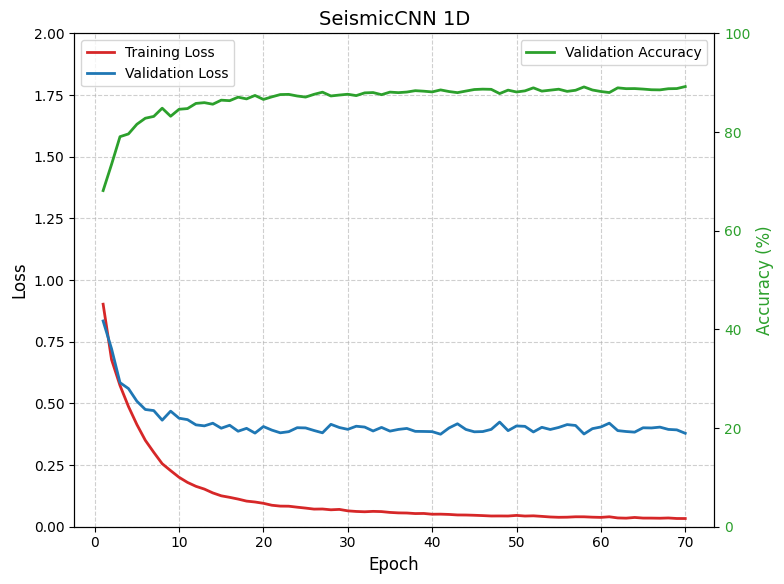

In [42]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN), loss_time[:NN-1], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN), val_loss_time[:NN-1], color='tab:blue', label='Validation Loss', linewidth=2)
    #ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN), val_accuracy_time[:NN-1], color='tab:green', label='Validation Accuracy', linewidth=2)
    #ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d)

## SeismicCNN (2D)

In [43]:
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, model_training_time_seismiccnn_2d) = train_model(model_seismiccnn_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_' )

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:05<09:50,  6.56s/it]

[Epoch 10] loss: 0.386 - accuracy: 85.783


 20%|██        | 20/100 [02:10<08:39,  6.50s/it]

[Epoch 20] loss: 0.289 - accuracy: 87.855


 30%|███       | 30/100 [03:15<07:39,  6.56s/it]

[Epoch 30] loss: 0.242 - accuracy: 88.217


 40%|████      | 40/100 [04:26<06:55,  6.92s/it]

[Epoch 40] loss: 0.208 - accuracy: 89.385


 50%|█████     | 50/100 [05:43<06:25,  7.71s/it]

[Epoch 50] loss: 0.189 - accuracy: 89.573


 60%|██████    | 60/100 [06:49<04:21,  6.53s/it]

[Epoch 60] loss: 0.176 - accuracy: 89.921


 70%|███████   | 70/100 [07:54<03:16,  6.54s/it]

[Epoch 70] loss: 0.167 - accuracy: 90.108


 80%|████████  | 80/100 [08:59<02:10,  6.51s/it]

[Epoch 80] loss: 0.155 - accuracy: 89.805


 82%|████████▏ | 82/100 [09:19<02:02,  6.82s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:590: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

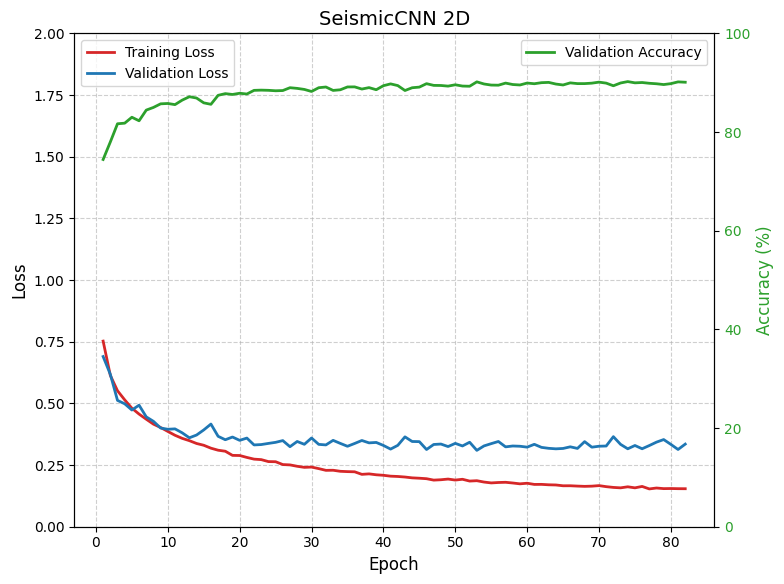

In [44]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, title = 'SeismicCNN 2D')

## QuakeXNet (1D)

In [45]:
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_quakexnet_1d, val_loss_time_quakexnet_1d, val_accuracy_time_quakexnet_1d, model_training_time_quakexnet_1d) = train_model(model_quakexnet_1d,
    train_loader_1d,  val_loader_1d, n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [00:55<08:20,  5.56s/it]

[Epoch 10] loss: 0.431 - accuracy: 80.908


 20%|██        | 20/100 [01:51<07:27,  5.59s/it]

[Epoch 20] loss: 0.369 - accuracy: 75.717


 30%|███       | 30/100 [02:46<06:34,  5.63s/it]

[Epoch 30] loss: 0.327 - accuracy: 78.680


 40%|████      | 40/100 [03:42<05:36,  5.61s/it]

[Epoch 40] loss: 0.291 - accuracy: 78.642


 44%|████▍     | 44/100 [04:10<05:18,  5.69s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:590: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

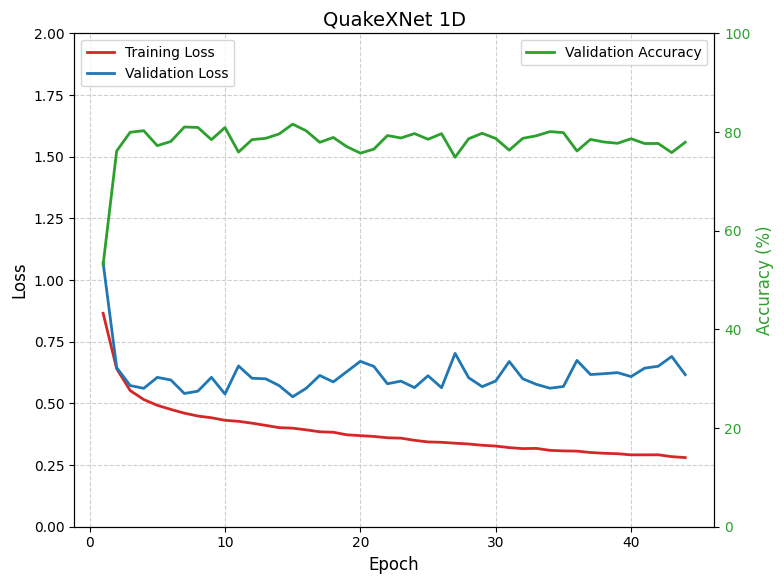

In [46]:
plot_model_training(loss_time_quakexnet_1d, val_loss_time_quakexnet_1d, val_accuracy_time_quakexnet_1d, title = 'QuakeXNet 1D')

## QuakeXNet (2D)

In [51]:
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_quakexnet_2d, val_loss_time_quakexnet_2d, val_accuracy_time_quakexnet_2d, model_training_time_quakexnet_2d) = train_model(model_quakexnet_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:01<09:12,  6.14s/it]

[Epoch 10] loss: 0.590 - accuracy: 80.882


 20%|██        | 20/100 [02:03<08:14,  6.18s/it]

[Epoch 20] loss: 0.543 - accuracy: 83.077


 30%|███       | 30/100 [03:05<07:12,  6.18s/it]

[Epoch 30] loss: 0.524 - accuracy: 82.884


 40%|████      | 40/100 [04:06<06:09,  6.15s/it]

[Epoch 40] loss: 0.509 - accuracy: 84.356


 50%|█████     | 50/100 [05:08<05:07,  6.16s/it]

[Epoch 50] loss: 0.504 - accuracy: 84.472


 60%|██████    | 60/100 [06:09<04:02,  6.07s/it]

[Epoch 60] loss: 0.496 - accuracy: 84.691


 70%|███████   | 70/100 [07:10<03:04,  6.14s/it]

[Epoch 70] loss: 0.489 - accuracy: 84.640


 80%|████████  | 80/100 [08:11<02:02,  6.14s/it]

[Epoch 80] loss: 0.485 - accuracy: 85.079


 90%|█████████ | 90/100 [09:12<01:00,  6.08s/it]

[Epoch 90] loss: 0.482 - accuracy: 84.653


100%|██████████| 100/100 [10:14<00:00,  6.15s/it]

[Epoch 100] loss: 0.475 - accuracy: 84.917



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:590: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path+m

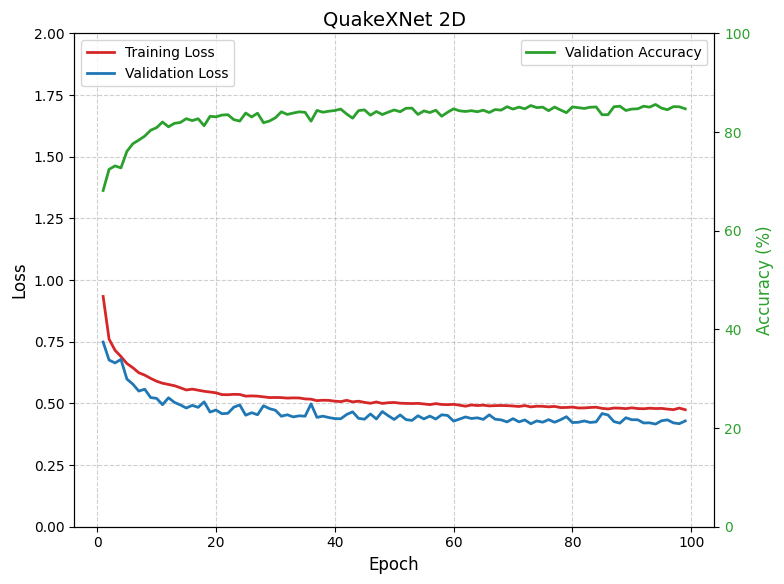

In [52]:
plot_model_training(loss_time_quakexnet_2d, val_loss_time_quakexnet_2d, val_accuracy_time_quakexnet_2d, title = 'QuakeXNet 2D')